# Predicting the ages of red giant stars from their element abundances
#### Ted Mackereth (U. Toronto)

In this notebook we are going to see how the theoretically predicted and observed correlation between stellar mass and the abundances of Carbon and Nitrogen in red giant branch stars can be used to train a data driven model which allows us to predict stellar ages for a large sample of stars for which we only have element abundance information.

Red giants are an excellent tool for studying the Milky Way. They are bright in the infra-red, and so we can see them across wide ranges of Galactocentric radii and through the layers of dust that hide their fainter main-sequence counterparts. However, because red giants occupy a very limited extent in color and magnitude space, through which their evolutionary tracks all pass, using the standard stellar ageing techniques that employ isochrones leads to large uncertainties on age. We can measure accurate and (relatively) precise ages in giants using 'Asteroseismology'. 

Asteroseismology is the study of the oscillations of stellar envelopes driven by sound waves propagating through the stellar interiors. Its geological equivalent is seismology on the earth, that peers into the center of the planet by analysing how earthquakes propagate through it. By carefully analysing light curves of stars (from missions like Kepler, which has detected 1000s of transiting exoplanets), we can detect the miniscule changes in the stellar brightness due to these oscillations. The oscillations generate a characteristic pattern in the fourier transform of the light curve, that allows us to infer the interior structure of the star, and therefore its density, and thus the mass. Since mass and age are tightly related in stars, we can then infer the age.

First, lets get some of the analysed data from Kepler red giants (taken from [this paper](https://ui.adsabs.harvard.edu/abs/2018ApJS..239...32P/abstract)) and have a look:

In [1]:
from astroquery.vizier import Vizier
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
%config InlineBackend.figure_format='retina'

we use astroquery to get the APOKASC-2 catalog from Vizier:

In [2]:
Vizier.ROW_LIMIT = -1
apokasc2 = Vizier.get_catalogs('J/ApJS/239/32')[0]
apokasc2[:10]

KIC,_2MASS,Teff,FeH,AFe,Numax,Dnu,ES,Fdnu,M_cor_,s_M_cor_,R_cor_,s_R_cor_,logg_seis_,s_logg_seis_,Rho,s_Rho,LogAge,Av,Notes,AP-1,KCat,Sloan,Simbad,_RA,_DE
,,K,dex(---),dex(---),uHz,uHz,,,Msun,,Rsun,,dex(cm / s2),,g / cm3,,Myr,mag,,,,,,deg,deg
int32,str16,float32,float32,float32,float32,float32,str8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str16,int16,str4,str5,str6,float64,float64
1027110,19250937+3644599,4177.6,-0.232,0.205,6.496,1.132,RGB,1.0458,0.985,0.044,23.412,0.017,1.692,0.007,0.00011,0.008,4.002,0.269,SeisUnc,0,KCat,Sloan,Simbad,291.28904,36.74997
1027337,19252021+3647118,4636.0,0.275,0.023,73.975,6.991,RGB,1.0333,1.227,0.038,7.544,0.014,2.772,0.007,0.004,0.007,3.798,0.214,,0,KCat,Sloan,Simbad,291.33421,36.78661
1160789,19233280+3652207,4729.6,-0.257,0.188,25.209,3.545,RC,0.9965,0.875,0.082,10.860,0.025,2.308,0.010,0.00096,0.008,3.889,0.009,,0,KCat,Sloan,Simbad,290.88667,36.87242
1160986,19234825+3649476,4339.7,0.135,0.029,--,--,REJECT,--,--,--,--,--,--,--,--,--,--,--,No Seis,0,KCat,Sloan,Simbad,290.95104,36.82989
1161447,19241746+3651460,4776.1,0.058,-0.006,37.066,4.153,RC,1.0030,1.460,0.076,11.540,0.022,2.478,0.010,0.0013,0.008,3.396,0.400,,0,KCat,Sloan,Simbad,291.07275,36.86278
1161618,19242614+3648478,4742.0,0.064,0.005,33.926,4.093,RC,1.0010,1.183,0.077,10.879,0.023,2.438,0.010,0.0013,0.008,3.639,0.199,,0,KCat,Sloan,Simbad,291.10892,36.81328
1162220,19245791+3653298,4190.1,0.083,0.070,11.000,1.669,RGB,1.0484,1.007,0.044,18.175,0.017,1.922,0.007,0.00024,0.008,4.056,0.181,,0,KCat,Sloan,Simbad,291.24129,36.89161
1162746,19252639+3649116,4798.1,-0.388,0.229,27.798,3.763,RC,0.9972,0.941,0.080,10.688,0.024,2.354,0.010,0.0011,0.008,3.786,0.172,,1,KCat,Sloan,Simbad,291.35996,36.81989


Notice that this catalog contains a whole bunch of information for each star, most of which we dont care so much about. However, it also contains information about mass and age, in the `M_cor_` and `LogAge` columns. We also get the ID of each star in the 2MASS survey, which is a photometric survey of many many stars in the near infra-red. This is important, because the stars in APOKASC-2 were actually taken from APOGEE, a spectroscopic survey of stars, also in the near infra-red. Since APOGEE selected stars from 2MASS, these IDs all correspond to the same object in the APOGEE DR16 catalogue. Let's get that catalogue now (again, from Vizier):

In [3]:
Vizier.ROW_LIMIT = -1
apogee = Vizier.get_catalogs('III/284/allstars')[0]
apogee[:10]

m_ID,ID,Nvis,RAJ2000,DEJ2000,SNR,SaFlag,HRV,e_HRV,s_HRV,errHRV,f_Teff,Teff,e_Teff,f_logg,logg,e_logg,f_Vmicro,Vmicro,Vmacro,f_Vsini,Vsini,f__M_H_,__M_H_,e__M_H_,f__a_M_,__a_M_,e__a_M_,Chi2,TClass,AFlag,f__C_Fe_,__C_Fe_,e__C_Fe_,f__CI_Fe_,__CI_Fe_,e__CI_Fe_,f__N_Fe_,__N_Fe_,e__N_Fe_,f__O_Fe_,__O_Fe_,e__O_Fe_,f__Na_Fe_,__Na_Fe_,e__Na_Fe_,f__Mg_Fe_,__Mg_Fe_,e__Mg_Fe_,f__Al_Fe_,__Al_Fe_,e__Al_Fe_,f__Si_Fe_,__Si_Fe_,e__Si_Fe_,f__P_Fe_,__P_Fe_,e__P_Fe_,f__S_Fe_,__S_Fe_,e__S_Fe_,f__K_Fe_,__K_Fe_,e__K_Fe_,f__Ca_Fe_,__Ca_Fe_,e__Ca_Fe_,f__Ti_Fe_,__Ti_Fe_,e__Ti_Fe_,f__TiII_Fe_,__TiII_Fe_,e__TiII_Fe_,f__V_Fe_,__V_Fe_,e__V_Fe_,f__Cr_Fe_,__Cr_Fe_,e__Cr_Fe_,f__Mn_Fe_,__Mn_Fe_,e__Mn_Fe_,f__Fe_H_,__Fe_H_,e__Fe_H_,f__Co_Fe_,__Co_Fe_,e__Co_Fe_,f__Ni_Fe_,__Ni_Fe_,e__Ni_Fe_,f__Cu_Fe_,__Cu_Fe_,e__Cu_Fe_,f__Ce_Fe_,__Ce_Fe_,e__Ce_Fe_,Gaia,Sp
,,,deg,deg,,,km / s,km / s,km / s,km / s,,K,K,,dex(cm / s2),dex(cm / s2),,km / s,km / s,,km / s,,dex(---),dex(---),,dex(---),dex(---),,,,,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,dex(---),dex(---),,
int16,str18,int16,float64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,int32,float64,float32,int32,float64,float64,int32,float64,int32,float64,float64,int32,float64,float64,float64,str5,int64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int64,str2
1,2M00000002+7417074,3,0.000103,74.285408,841.51,0,-51.731602,0.000874,0.131481,0.001533,512,3723.226,61.795,33554944,0.7549,0.0491,0,1.769375,3.220016,65536,--,0,-0.145402,0.008504,0,0.033469,0.007072,11.437,Mg_d,0,0,0.002680,0.004477,0,-0.001852,0.009625,0,0.220700,0.009904,0,0.057629,0.006279,512,--,--,0,0.051319,0.011574,0,-0.016807,0.022021,0,-0.015764,0.009894,0,0.147427,0.032112,0,-0.009613,0.028675,512,--,--,0,-0.003590,0.010218,512,--,--,512,--,--,0,0.080853,0.023126,0,0.032448,0.024677,512,--,--,0,-0.165732,0.010530,0,0.017342,0.019727,0,-0.029778,0.013713,512,--,--,512,--,--,538028216707715712,Sp
1,2M00000019-1924498,2,0.000832,-19.413851,188.96,0,19.000099,0.022991,0.235452,0.032342,0,5508.860,110.270,67108864,4.3059,0.0948,0,0.804302,1.000000,0,7.15501,0,-0.279469,0.01008,0,0.083089,0.008506,2.5426,GKd_b,0,0,0.043904,0.021667,0,0.063407,0.024953,0,-0.150577,0.045383,512,--,--,512,--,--,0,0.154221,0.012348,0,0.239444,0.019257,0,0.046871,0.011412,512,--,--,0,0.069816,0.050095,0,0.201285,0.032868,0,0.101428,0.015935,0,0.236503,0.051829,0,0.171830,0.092399,512,--,--,0,-0.030977,0.061089,0,-0.071816,0.022912,0,-0.285279,0.010201,0,-0.181656,0.156750,0,0.020520,0.018092,0,0.028205,0.077440,512,--,--,2413929812587459072,Sp
2,2M00000032+5737103,6,0.001335,57.619530,120.47,512,-20.289900,0.040431,0.060118,0.068702,0,6318.045,156.817,67108864,3.8574,0.0798,0,2.434557,1.000000,0,14.98994,0,-0.154659,0.018166,0,0.054616,0.015614,1.4934,Fd_d,0,0,0.146634,0.036354,0,0.095602,0.029119,16384,--,--,512,--,--,512,--,--,0,0.150631,0.021675,0,-0.002961,0.039349,0,0.078300,0.020240,512,--,--,0,-0.065004,0.059136,0,0.123345,0.071922,0,-0.103540,0.036094,512,--,--,512,--,--,512,--,--,512,--,--,0,0.090814,0.038470,0,-0.168239,0.019294,16384,--,--,0,-0.023950,0.034845,512,--,--,512,--,--,422596679964513792,Sp
2,2M00000032+5737103,6,0.001335,57.619530,215.66,0,-20.542200,0.03

We need to now cross-match these catalogues together, so that we can combine the asteroseismic information from APOKASC with the element abundances in APOGEE. We use `np.intersect1d` for this task, first correcting the format of the APOKASC ID's to match the APOGEE ones (prepending a 2M)

In [4]:
correctedIDs = np.array(['2M'+apokasc2['_2MASS'][i] for i in range(len(apokasc2))])

_, idx1, idx2 = np.intersect1d(apogee['ID'].data.data, correctedIDs, return_indices=True)

full_apogee = apogee
apogee = apogee[idx1]
apokasc2 = apokasc2[idx2]

Now let's take a look at our combined and matched data.  We want to find some element abundance that correlates with the mass of the star. Luckily, it was predicted by Salaris+ (2016) that there should be a relationship between the surface abundances of Carbon and Nitrogen of stars on the red giant branch and their mass on the main sequence. The reason for this is complex, but a simplified explanation is that C and N are produced at the surface of the core in CN-cycle burning. Once the star ascends from the main sequence to become a giant, large scale convection stars to occur, dredging up material from the core to the surface (this is called the first dredge up, or FDU). Since the depth of the convection is mass dependent, the change in the surface abundance (due to the dredged up material) is different between low and high mass stars. This means that red giant branch stars' C and N is dependent on mass.

We can check this hypothesis by plotting the asteroseismic mass against the APOGEE measurement of C and N. We'll take the ratio between the abundance of C and N, since this is where this effect appears strongest:

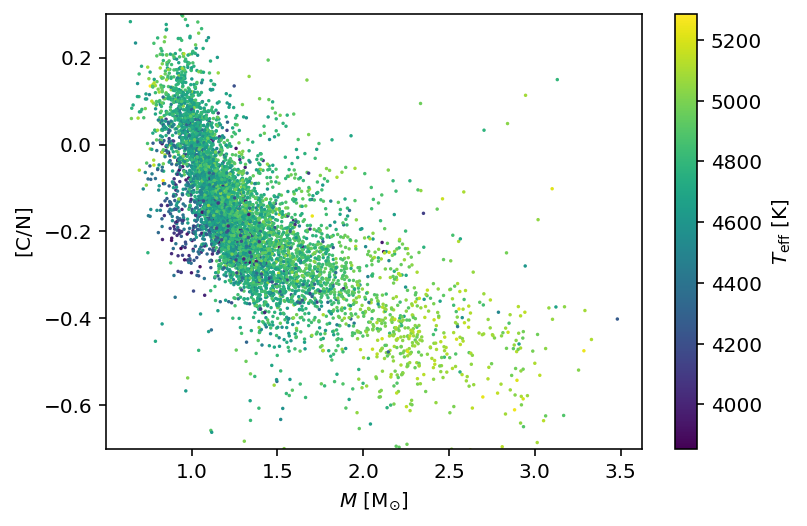

In [5]:
plt.scatter(apokasc2['M_cor_'], apogee['__C_Fe_']-apogee['__N_Fe_'], s=3., lw=0., c=apogee['Teff'])
plt.ylim(-0.7,0.3)
plt.xlabel(r'$M\ \mathrm{[M_{\odot}]}$')
plt.ylabel(r'$\mathrm{[C/N]}$')

plt.colorbar(label='$T_{\mathrm{eff}}\ \mathrm{[K]}$')

Notice that the higher mass a star is, the lower the [C/N] ratio. I coloured the points by the effective temperature $T_{\mathrm{eff}}$, just to see if there are strong trends there too. Looks like there might be - this is because the hotter stars are more likely to be young, or high mass.

This indicates that we should be able to derive some empirical model for the mass (or age) that will allow us to determine these parameters for all the stars in APOGEE for which we measure Carbon and Nitrogen abundances.

## Building the model

We are going to build our model this using a framework called Keras, which is now built in to Tensorflow, one of the more popular libraries for machine learning. Keras is great, because it abstracts away a lot of the details of how to code up an efficient neural network, and just allows us to drop in different models and setups for testing purposes. We'll use its simplest form, but it has a whole load of complexity if you need to do more detailed tasks.

Simple neural networks are formed from layers of 'neurons' or nodes, that are connected in different ways and with some 'activation' function which gets applied to the inputs to generate the output. These activation functions are typically parameterized by a 'weight' which determines how the signal in is transformed to the signal out. By optimizing these weights to produce the correct output for a given input, we can 'train' a model that can predict new outputs from new inputs.

The simplest neural networks tend to have what we call 'fully connected' or 'dense' layers, where every node in one layer is connected to every node in the next. We call the machine learning 'deep learning' when we use many layers and many nodes (i.e. the model has many, many parameters!). 

Lets make a simple neural net in Keras. We'll use 2 main layers with 12 neurons, plus the input and output layers, whose dimensions should match the input/output data. To start, lets see if we can use this predict mass $M$ and age, from $T_{\mathrm{eff}}$, $\log(g)$, $\mathrm{[Fe/H]}$, $\mathrm{[C/Fe]}$, and $\mathrm{[N/Fe]}$ (i.e. 2 outputs for 5 inputs).

In [6]:
from tensorflow import keras


In [7]:
#start with an input layer
inputs = keras.Input(shape=(5,))
#now we add the Dense layers (indicating the previous layer in the brackets following the layer declaration
layer1 =keras.layers.Dense(12, activation='relu')(inputs)
layer2 = keras.layers.Dense(12, activation='relu')(layer1)
#then the output layer
outputs = keras.layers.Dense(2)(layer2)
# then we put that all together in the Model object
model = keras.Model(inputs=inputs, outputs=outputs, name='test')
#and we can print a summary to check it all went to plan
model.summary()

Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 12)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 26        
Total params: 254
Trainable params: 254
Non-trainable params: 0
_________________________________________________________________


Now we've declared the model, we need to compile it, providing a loss function and the optimizer we want to use. There are many choices for these, but for the purposes of the tutorial, I've just used some commonly used ones:

In [8]:
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

Now we prepare our training data. We'll just stack all the relevant arrays from the catalogues we extracted earlier, then we remove all the problematic entries (usually where either catalogue has missing data). Finally, we'll scale the data by each of the features' median value. This means that all the data ends up on similar scales, and we dont have one axis with a large range (e.g. $T_{\mathrm{eff}}$ in the thousands) and another with a small scale (e.g. the abundances).

In [9]:
fullx = np.dstack([apogee['Teff'].data.data, apogee['logg'].data.data, apogee['__Fe_H_'].data.data, apogee['__C_Fe_'].data.data, apogee['__N_Fe_'].data.data])[0]
fully = np.dstack([apokasc2['M_cor_'].data.data, apokasc2['LogAge'].data.data])[0]

#remove non-finite entries!
mask = np.all(np.isfinite(fullx), axis=1) & np.all(np.isfinite(fully), axis=1)
fullx, fully = fullx[mask], fully[mask]

scaling_x = np.median(fullx, axis=0)
scaling_y = np.median(fully, axis=0)

fullx, fully = fullx/scaling_x, fully/scaling_y

The method `.fit` is where we perform the training. Since we want to ensure that we havent 'overtrained' the model, we'll keep some data behind for later... We specify here the batch size, which is the number of training data that we give the network at each training step, and the number of epochs, which is the number of times the network sees the entire data set.

In [10]:
x_train, y_train = fullx[:-600], fully[:-600]

model.fit(x_train, y_train, epochs=3000, batch_size=300)

Epoch 1/3000
20/20 [==============================] - 1s 3ms/step - loss: 1.2540 - accuracy: 0.5268
Epoch 2/3000
20/20 [==============================] - 0s 1ms/step - loss: 0.8623 - accuracy: 0.5295
Epoch 3/3000
20/20 [==============================] - 0s 1ms/step - loss: 0.6197 - accuracy: 0.5283
Epoch 4/3000
20/20 [==============================] - 0s 1ms/step - loss: 0.4516 - accuracy: 0.5802
Epoch 5/3000
20/20 [==============================] - 0s 1ms/step - loss: 0.3267 - accuracy: 0.6812
Epoch 6/3000
20/20 [==============================] - 0s 1ms/step - loss: 0.2463 - accuracy: 0.7237
Epoch 7/3000
20/20 [==============================] - 0s 2ms/step - loss: 0.1928 - accuracy: 0.7234
Epoch 8/3000
20/20 [==============================] - 0s 3ms/step - loss: 0.1470 - accuracy: 0.7307
Epoch 9/3000
20/20 [==============================] - 0s 3ms/step - loss: 0.1091 - accuracy: 0.7261
Epoch 10/3000
20/20 [==============================] - 0s 2ms/step - loss: 0.0792 - accuracy: 0.7227

after running this fairly long training sequence, we hope that we can predict the mass and age of the validation set with some accuracy! Remember that this data should be entirely new to the network, and so is a fairly good way to check that it really does predict the right ages and masses! We use `.predict` for this:

In [ ]:
#predict the validation sample: the last 600 entries in the table
predictions = model.predict(fullx[-600:])

Since we have predictions _and_ real measurements for the validation set, we can just check them against each other:

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)

#remember that we scaled our input/output, so we re-scale and convert from Myr to Gyr!
ax[0].scatter(10**(predictions[:,1]*scaling_y[1])/1e3, 10**(fully[-600:,1]*scaling_y[1])/1e3, s=1.)
ax[0].set_xlim(0.,14.)
ax[0].plot([0.,14.], [0.,14.])

ax[0].set_xlabel(r'predicted age [Gyr]')
ax[0].set_ylabel(r'APOKASC-2 age [Gyr]')

ax[1].scatter(predictions[:,0]*scaling_y[0], fully[-600:,0]*scaling_y[0], s=1.)
ax[1].plot([0.5,3.5], [0.5,3.5])
ax[1].set_xlabel(r'predicted mass $\mathrm{[M_\odot]}$')
ax[1].set_ylabel(r'APOKASC-2 mass $\mathrm{[M_\odot]}$')

This might look like the NN has done horribly, since the scatter is very high. However, we should bear in mind that the average uncertainty on ages from APOKASC-2 is about 30-40%, so we arent doing that badly! Ideally we would use the uncertainty information in our neural network - for that we need a Bayesian neural network, which gets more complex...

## Predicting ages for ~400,000 APOGEE stars

now we have a model, we can apply it to predict the rest of the stars in APOGEE for which we had no asteroseismic information. To do this we just use `.predict` and give it the same columns from the whole catalogue:

In [ ]:
apogee_x = np.dstack([full_apogee['Teff'].data.data, full_apogee['logg'].data.data, full_apogee['__Fe_H_'].data.data, full_apogee['__C_Fe_'].data.data, full_apogee['__N_Fe_'].data.data])[0]
# dont forget the scaling!!
apogee_x = apogee_x/scaling_x
predictions = model.predict(apogee_x)

Lets look at mass vs C/N again:

In [ ]:
plt.scatter(predictions[:,0]*scaling_y[0], full_apogee['__C_Fe_']-full_apogee['__N_Fe_'], s=0.1, lw=0.)
plt.ylim(-0.7,0.5)
plt.xlim(0.,3.5)
plt.xlabel(r'$M\ \mathrm{[M_\odot]}$')
plt.ylabel(r'$\mathrm{[C/N]}$')

oh... this doesnt look very good at all! What happened?! Well, we can investigate this by looking in more detail at the properties of those stars that are behaving badly. Lets see what sort of surface gravities they have:

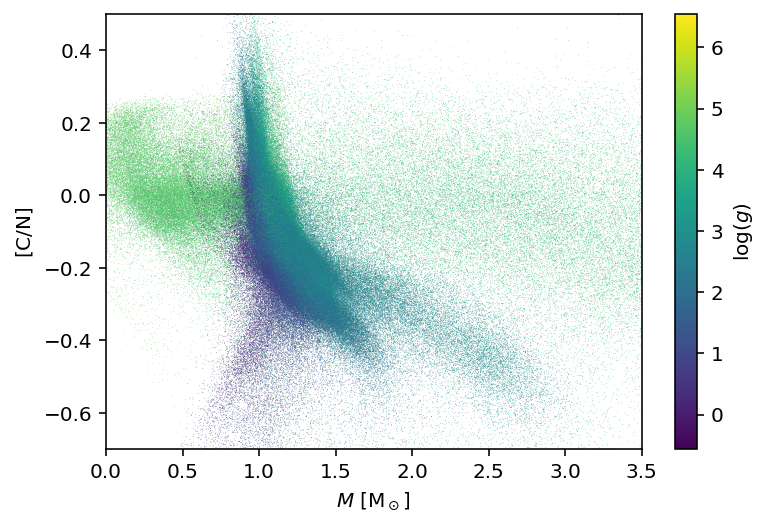

In [15]:
plt.scatter(predictions[:,0]*scaling_y[0], full_apogee['__C_Fe_']-full_apogee['__N_Fe_'], s=0.1, lw=0., c=full_apogee['logg'])
plt.ylim(-0.7,0.5)
plt.xlim(0.,3.5)
plt.xlabel(r'$M\ \mathrm{[M_\odot]}$')
plt.ylabel(r'$\mathrm{[C/N]}$')
plt.colorbar(label=r'$\log(g)$')

ah - looks like the points that are way out of where the training data were are all at quite high (or low) $\log(g)$. The reason for this is that the stars in the training set were all in a small range of $\log(g)$ on the red giant branch. This is because seismology only works well in small ranges of luminosity, which correlates with $\log(g)$ for red giants. What if we select out only stars with $1 < \log(g) < 3.$?

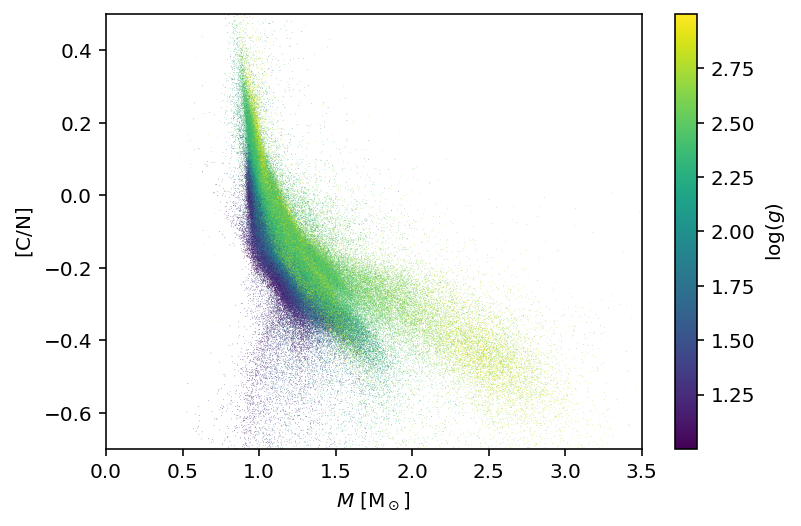

In [16]:
mask = (full_apogee['logg'] > 1) & (full_apogee['logg'] < 3)
plt.scatter((predictions[:,0]*scaling_y[0])[mask], (full_apogee['__C_Fe_']-full_apogee['__N_Fe_'])[mask], s=0.1, lw=0., c=full_apogee['logg'][mask])
plt.ylim(-0.7,0.5)
plt.xlim(0.,3.5)
plt.xlabel(r'$M\ \mathrm{[M_\odot]}$')
plt.ylabel(r'$\mathrm{[C/N]}$')
plt.colorbar(label=r'$\log(g)$')

This looks at least a little better! What else could we look at to 'sanity check' our results? One very commonly used diagram in Galactic archaeology is the [Fe/H]-[Mg/Fe] plane. We can colour this by age and see if any interesting trends appear:

Text(0, 0.5, '$\\mathrm{[Mg/Fe]}$')

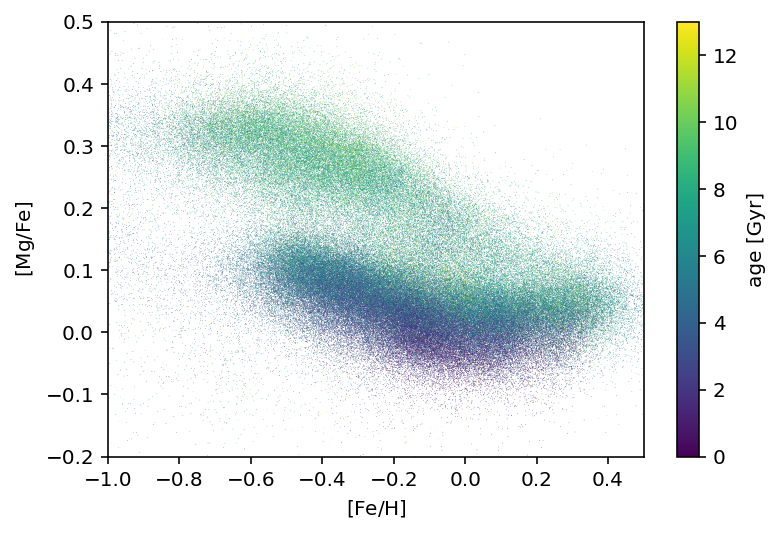

In [17]:

plt.scatter(full_apogee['__Fe_H_'][mask], full_apogee['__Mg_Fe_'][mask], c=10**(predictions[:,1]*scaling_y[1])[mask]/1e3, s=0.1, lw=0., vmin=0., vmax=13.)
plt.colorbar(label=r'age [Gyr]')

plt.xlim(-1.,0.5)
plt.ylim(-0.2,0.5)

plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$\mathrm{[Mg/Fe]}$')

This is looking pretty nice! You can compare it with some other papers that look at this plane coloured by age, e.g. [Martig+ 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.456.3655M/abstract), [Haywood+ 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...589A..66H/abstract), [Mackereth+ 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.489..176M/abstract), [Miglio+ 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..85M/abstract).

Notice that the upper sequence of stars is much older than the lower one, and contains many stars at a very simialr age of $\simeq 10$-$11$ Gyr. This is the 'high-$\alpha$' population in the Milky Way, and is thought to be related with the some of the earliest star formation that occurred in our galaxy. These stars are in a configuration in position and velocity in the Galaxy that they formed in turbulent, rapidly star-forming gas. 

The lower, younger sequence is the 'low-$\alpha$' population. The sun is a member of this later-formed population of stars, which are in a much thinner, dynamically cold configuration in position and velocity - indicating their formation in a later, less violent phase of the Milky Way's history.

### 